In [154]:
import pandas as pd
import numpy as np

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, classification_report

import xgboost as xgb
import random

import scipy

In [2]:
# data_dir = "../../2021_09_01_VarChAMP_local/6.downstream_analysis/results/"
# feature_type = "_normalized_feature_selected"

In [31]:
data_dir = "../../raw_images/cpjump/results"
feature_type = "_annotated_normalized_feature_selected"
plate = "BR00121425_single_cell_profile"

In [32]:
sc_profiles_path = f"{data_dir}/{plate}{feature_type}.csv.gz"

sc_profiles = pd.read_csv(sc_profiles_path)

In [5]:
# sc_profiles_path = (
#     f"{data_dir}B1A1R1_P1T1_single_cell_profile{feature_type}.csv.gz"
# )

# sc_profiles = pd.read_csv(sc_profiles_path)

In [36]:
# sc_profiles.drop(["ObjectNumber", "ObjectNumber_Cells"], axis=1, inplace=True)
meta_col = [i for i in sc_profiles.columns if "Metadata_" in i]
feat_col = [i for i in sc_profiles.columns if "Metadata_" not in i]

### Variant against Reference Classification

In [ ]:
treatment_profiles = sc_profiles[
    ~sc_profiles["Metadata_broad_sample"].isna().reset_index(drop=True)
].reset_index(drop=True)

In [159]:
cpd_lst = list(treatment_profiles["Metadata_broad_sample"].unique())
well_count = {cpd: treatment_profiles[treatment_profiles["Metadata_broad_sample"]==cpd]
              ['Metadata_Well'].unique().size for cpd in cpd_lst}
cpd_keep = [i for i in cpd_lst if well_count[i]==1]
cpd_keep = random.sample(cpd_keep, 64)

In [160]:
treatment_profiles = treatment_profiles[treatment_profiles['Metadata_broad_sample'].isin(cpd_keep)]

In [106]:
# treatment_profiles = sc_profiles[
#     ~sc_profiles["Metadata_broad_sample"].isna().reset_index(drop=True)
# ].reset_index(drop=True)
# cpd_lst = list(treatment_profiles["Metadata_broad_sample"].unique())
# group1 = random.sample(cpd_lst, len(cpd_lst)//2)
# group2 = [i for i in cpd_lst if i not in group1]
# group_dict = dict(zip(group1, group2))

In [161]:
treatment_group = treatment_profiles.groupby('Metadata_broad_sample').groups

In [164]:
f1score_macro_list = []
f1score_macro_shuff_list = []
gene_list = []
pair_list = []
feat_list = []

for i in tqdm(range(len(cpd_keep) - 1)):
    cpd_one = cpd_keep[i]
    for j in range(i + 1, len(cpd_keep)):
        cpd_two = cpd_keep[j]

        gene_profiles = treatment_profiles.loc[treatment_group[cpd_one]]
        comp_profiles = treatment_profiles.loc[treatment_group[cpd_two]]


        gene_profiles["Label"] = 1
        comp_profiles["Label"] = 0
        all_profiles = pd.concat(
                [gene_profiles, comp_profiles], ignore_index=True
            )
        X, y = all_profiles[feat_col], all_profiles[["Label"]]

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1
        )

        # Create shuffled train labels
    #     y_train_shuff = y_train.copy()
    #     y_train_shuff["Label"] = np.random.permutation(y_train.values)

        # Model train and predict
        model = xgb.XGBClassifier().fit(X_train, y_train)
        preds = model.predict(X_test)

        # Store feature importance
        feat_importances = pd.Series(
            model.feature_importances_, index=X_train.columns
        )
        feat_list.append(feat_importances)

        #         # Model trained with shuffled label data (null)
        #         model_shuff = xgb.XGBClassifier().fit(X_train, y_train_shuff)
        #         preds_shuff = model_shuff.predict(X_test)

        # Evaluate with metrics
        f1score_macro = f1_score(y_test, preds, average="macro")
        #         f1score_macro_shuff = f1_score(y_test, preds_shuff, average="macro")

        f1score_macro_list.append(f1score_macro)
        #         f1score_macro_shuff_list.append(f1score_macro_shuff)
        gene_list.append(cpd_one)
        pair_list.append(cpd_two)

  0%|          | 0/63 [00:00<?, ?it/s]

In [109]:
df_feat_one = pd.DataFrame({"Gene": gene_list, "Variant": pair_list})
df_feat_two = pd.DataFrame(feat_list)
df_feat = pd.concat([df_feat_one, df_feat_two], axis=1)

In [110]:
df_feat.to_csv(
    f"{data_dir}{protein_suffix}_var_feat_importance{feature_type}.csv",
    index=False,
)

In [111]:
len(f1score_macro_list)

153

In [165]:
result_csv = pd.DataFrame(
    {
        "Gene": gene_list,
        "Variant": pair_list,
        "F1_Score": f1score_macro_list
        # "F1_Score_shuffled": f1score_macro_shuff_list,
    }
)
result_csv.to_csv(
    f"{data_dir}/compound_pred_{feature_type}.csv",
    index=False,
)

### Controls - Well Location Classification

In [33]:
control_profiles = sc_profiles[
    sc_profiles["Metadata_broad_sample"].isna()
].reset_index(drop=True)

control_group = control_profiles.groupby("Metadata_Well").groups

In [49]:
control_group = control_profiles.groupby("Metadata_Well").groups
well_list = list(control_profiles["Metadata_Well"].unique())

In [12]:
f1score_macro_list = []
gene_list = []
pair_list = []
f1score_macro_shuff_list = []
feat_list = []

for i in range(len(well_list) - 1):
    well_one = well_list[i]
    for j in tqdm(range(i + 1, len(well_list))):
        well_two = well_list[j]

        df_well_one = control_profiles.loc[control_group[well_one]]
        df_well_two = control_profiles.loc[control_group[well_two]]

        df_well_one["Label"] = 1
        df_well_two["Label"] = 0

        all_profiles = pd.concat([df_well_one, df_well_two], ignore_index=True)
        X, y = all_profiles[feat_col], all_profiles[["Label"]]

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1
        )

        # Create shuffled train labels
        #     y_train_shuff = y_train.copy()
        #     y_train_shuff["Label"] = np.random.permutation(y_train.values)

        # Model train and predict
        model = xgb.XGBClassifier().fit(X_train, y_train)
        preds = model.predict(X_test)

        # Store feature importance
        feat_importances = pd.Series(
            model.feature_importances_, index=X_train.columns
        )
        feat_list.append(feat_importances)

        #             model_shuff = xgb.XGBClassifier().fit(X_train, y_train_shuff)
        #             preds_shuff = model_shuff.predict(X_test)

        # Evaluate with metrics
        f1score_macro = f1_score(y_test, preds, average="macro")
        #             f1score_macro_shuff = f1_score(y_test, preds_shuff, average="macro")

        #             f1score_macro_shuff_list.append(f1score_macro_shuff)
        f1score_macro_list.append(f1score_macro)
        gene_list.append(well_one)
        pair_list.append(well_two)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
ctrl_feat_one = pd.DataFrame({"Gene": gene_list, "Variant": pair_list})
ctrl_feat_two = pd.DataFrame(feat_list)
ctrl_feat = pd.concat([ctrl_feat_one, ctrl_feat_two], axis=1)

In [16]:
ctrl_feat.to_csv(
    f"{data_dir}ctrl_feat_importance{feature_type}.csv",
    index=False,
)

In [17]:
control_csv = pd.DataFrame(
    {
        "Treatment": gene_list,
        "Well_Pair": pair_list,
        "F1_Score": f1score_macro_list
        # "F1_Score_shuffled": f1score_macro_shuff_list,
    }
)
control_csv.to_csv(
    f"{data_dir}control_prediction{feature_type}.csv",
    index=False,
)

In [18]:
control_csv

,Treatment,Well_Pair,F1_Score
0,A05,A20,0.873941
1,A05,B12,0.857850
2,A05,B13,0.916295
3,A05,C09,0.932413
4,A05,C16,0.915825
...,...,...,...
2011,O11,P11,0.764310
2012,O11,P24,0.932127
2013,O12,P11,0.824010
2014,O12,P24,0.966330


In [28]:
df_well = pd.read_csv('BR00121425.csv')
df_well

,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Count_Cells,Metadata_Count_CellsIncludingEdges,Metadata_Count_Cytoplasm,Metadata_Count_Nuclei,Metadata_Count_NucleiIncludingEdges,Metadata_Object_Count,Image_Granularity_10_AGP,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,BR00121425,A01,9,1536.0,1720.0,1536.0,1536.0,1720.0,1536,3.804578,...,58.128264,57.891778,54.025579,54.296074,53.784118,54.264500,54.751629,56.083055,54.495342,56.143226
1,BR00121425,A02,9,1638.0,1851.0,1638.0,1638.0,1851.0,1638,3.418988,...,69.045487,68.514572,63.925842,64.452621,63.880146,64.438313,64.935333,66.774926,64.918013,66.695783
2,BR00121425,A03,9,1813.0,2064.0,1813.0,1813.0,2064.0,1813,3.436863,...,53.962677,53.468636,50.307543,50.564112,50.349373,50.804767,50.927844,52.173601,51.018266,52.359216
3,BR00121425,A04,9,1890.0,2095.0,1890.0,1890.0,2095.0,1890,2.995552,...,56.310525,55.459726,52.042298,52.485576,52.182421,52.665204,52.906175,54.447889,53.047086,54.514131
4,BR00121425,A05,9,1924.0,2119.0,1924.0,1924.0,2119.0,1924,3.415250,...,54.162827,52.949430,50.126778,50.390310,50.137350,50.705529,50.950715,52.211797,50.987892,52.514226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,BR00121425,P20,9,1460.0,1632.0,1460.0,1460.0,1632.0,1460,3.039396,...,32.490915,32.109682,29.975073,30.278136,29.992891,30.250245,30.492269,31.426101,30.487478,31.396251
380,BR00121425,P21,9,394.0,442.0,394.0,394.0,442.0,394,2.735164,...,22.876807,22.506967,21.159320,21.253429,21.025828,21.265181,21.578242,22.218869,21.446855,22.126793
381,BR00121425,P22,9,1519.0,1691.0,1519.0,1519.0,1691.0,1519,2.795665,...,28.139448,28.105485,26.115582,26.336469,26.081936,26.302242,26.523964,27.357752,26.460637,27.194374
382,BR00121425,P23,9,1391.0,1535.0,1391.0,1391.0,1535.0,1391,2.848995,...,15.477182,15.148437,14.475958,14.565782,14.417433,14.530295,14.663370,14.996223,14.610082,14.990295


In [42]:
meta_well = [i for i in df_well.columns if 'Metadata' in i]
feat_well = [i for i in df_well.columns if 'Metadata' not in i]

In [48]:
df_well = df_well.loc[:, meta_well + feat_col]

ctrl_wells = control_profiles.Metadata_Well.unique()
df_well_controls = df_well[df_well['Metadata_Well'].isin(ctrl_wells)].reset_index(drop=True)

In [61]:
cos_sim_list = []
gene_list = []
pair_list = []
for i in tqdm(range(len(well_list) - 1)):
    well_one = well_list[i]
    df_well_one = df_well_controls[df_well_controls['Metadata_Well']==well_one][feat_col].values.squeeze()
    for j in range(i + 1, len(well_list)):
        well_two = well_list[j]
        df_well_two = df_well_controls[df_well_controls['Metadata_Well']==well_two][feat_col].values.squeeze()
        
        cos_sim = scipy.spatial.distance.cosine(df_well_one, df_well_two)
        
        cos_sim_list.append(cos_sim)
        gene_list.append(well_one)
        pair_list.append(well_two)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [67]:
cluster_csv = pd.DataFrame(
    {
        "Well_One": gene_list,
        "Well_Two": pair_list,
        "Cosine": cos_sim_list
    }
)

In [ ]:
def plot_feature_correlations(Xinput):
  sns.clustermap(
      np.corrcoef(Xinput.transpose()),
      metric="cosine",
      vmin=-1,
      vmax=1,
      cmap=sns.diverging_palette(20, 220, n=200)
      ).fig.suptitle(f"")

In [125]:
len(well_list)

64

### Visualization

In [3]:
import seaborn as sb
import matplotlib.pyplot as plt

In [7]:
control_csv = pd.read_csv(f"{data_dir}control_prediction{feature_type}.csv")

In [129]:
result_csv = pd.read_csv(f"{data_dir}protein_variant_prediction_annotated_normalized_feature_selected.csv")

In [166]:
control_csv["Type"] = "Control"
result_csv['Type'] = 'Compound'
all_csv = pd.concat([control_csv, result_csv], ignore_index=True)

In [179]:
thresh = np.percentile(control_csv["F1_Score"], 95)
num_pass = np.where(result_csv['F1_Score']> thresh)[0].size

In [180]:
print(f'95% threshold for controls: {thresh}')
print(f'Number of compound pairs pass threshold: {num_pass}')

95% threshold for controls: 0.9658994032395568
Number of compound pairs pass threshold: 1087


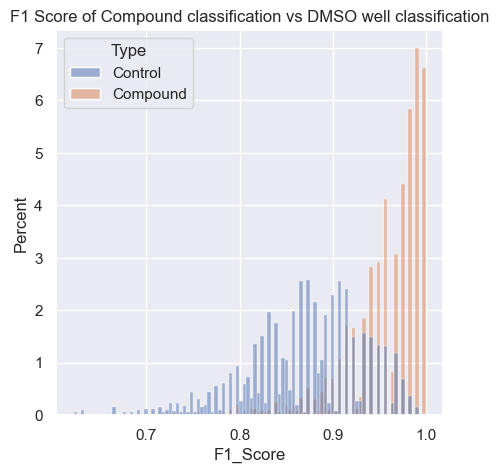

In [169]:
plt.figure()
sb.histplot(data=all_csv, x="F1_Score", hue="Type", bins=100, stat='percent')
plt.title("F1 Score of Compound classification vs DMSO well classification")
plt.show()

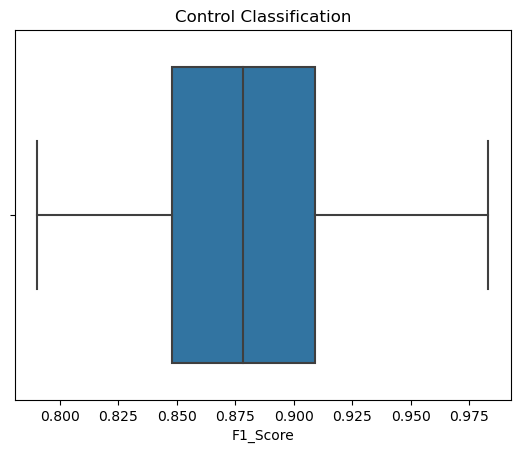

In [124]:
sb.boxplot(data=control_csv, x="F1_Score")
plt.title("Control Classification")
plt.show()

In [9]:
# Pivot and rescale for visualization
X = control_csv.pivot(
    index="Treatment", columns="Well_Pair", values="F1_Score"
)

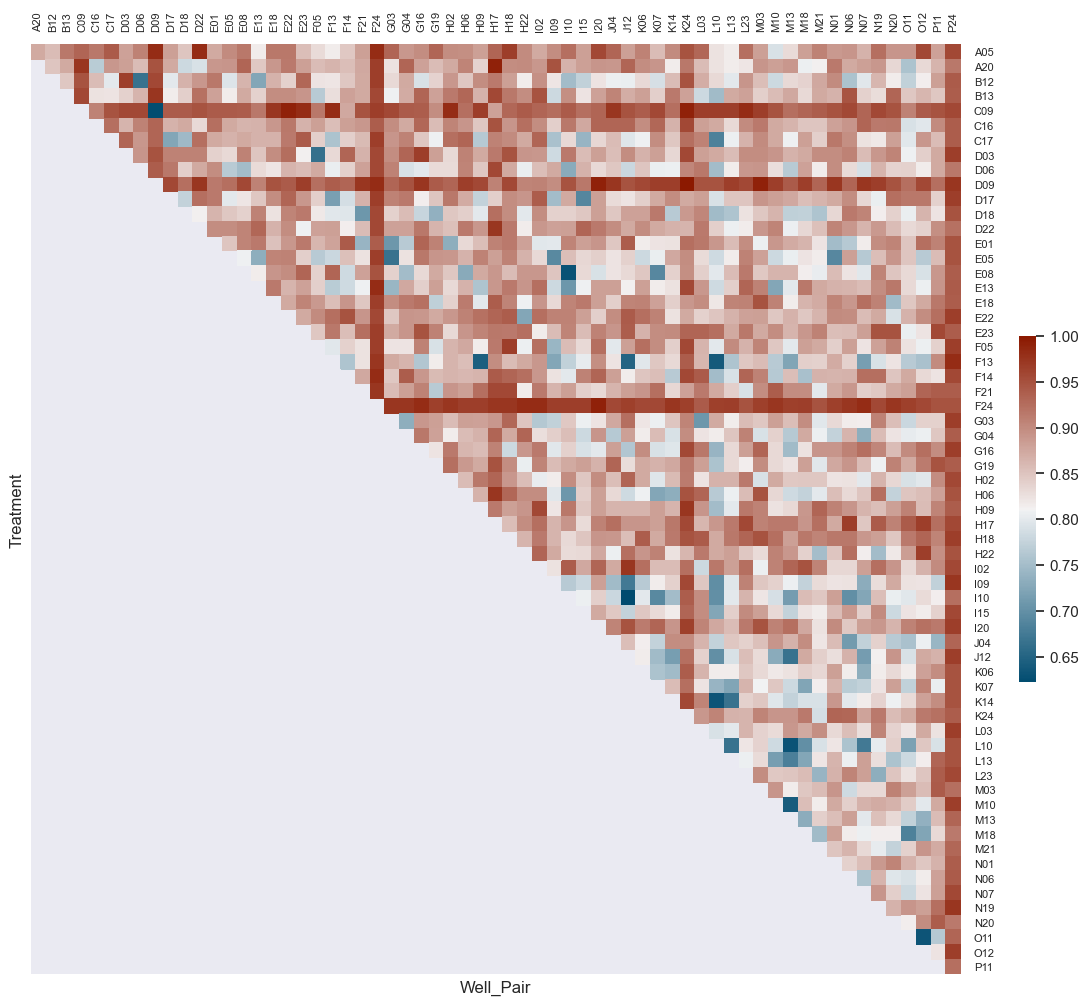

In [26]:
sb.set(rc={"figure.figsize": (15, 15)})
colmap = sb.diverging_palette(240, 15, s=100, l=30, as_cmap=True)

ax = sb.heatmap(
    X,
    cmap=colmap,
    square=True,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={"shrink": 0.30},
)
plt.tick_params(
    axis="both",
    which="major",
    rotation=90,
    labelsize=8,
    labelbottom=False,
    bottom=False,
    top=False,
    labeltop=True,
    right=False,
    labelright=True,
    left=False,
    labelleft=False,
)
plt.yticks(rotation=0)
# ax.set_aspect("equal")
plt.show()

In [80]:
cluster_csv['1-COS'] = cluster_csv['Cosine'].apply(lambda x: 1-x)

In [122]:
# Pivot and rescale for visualization
Y = cluster_csv.pivot_table(
    index="Well_One", columns="Well_Two", values="Cosine"
)

In [118]:
for well in Y.columns[:-1]:
    Y.loc[well, well]= 1

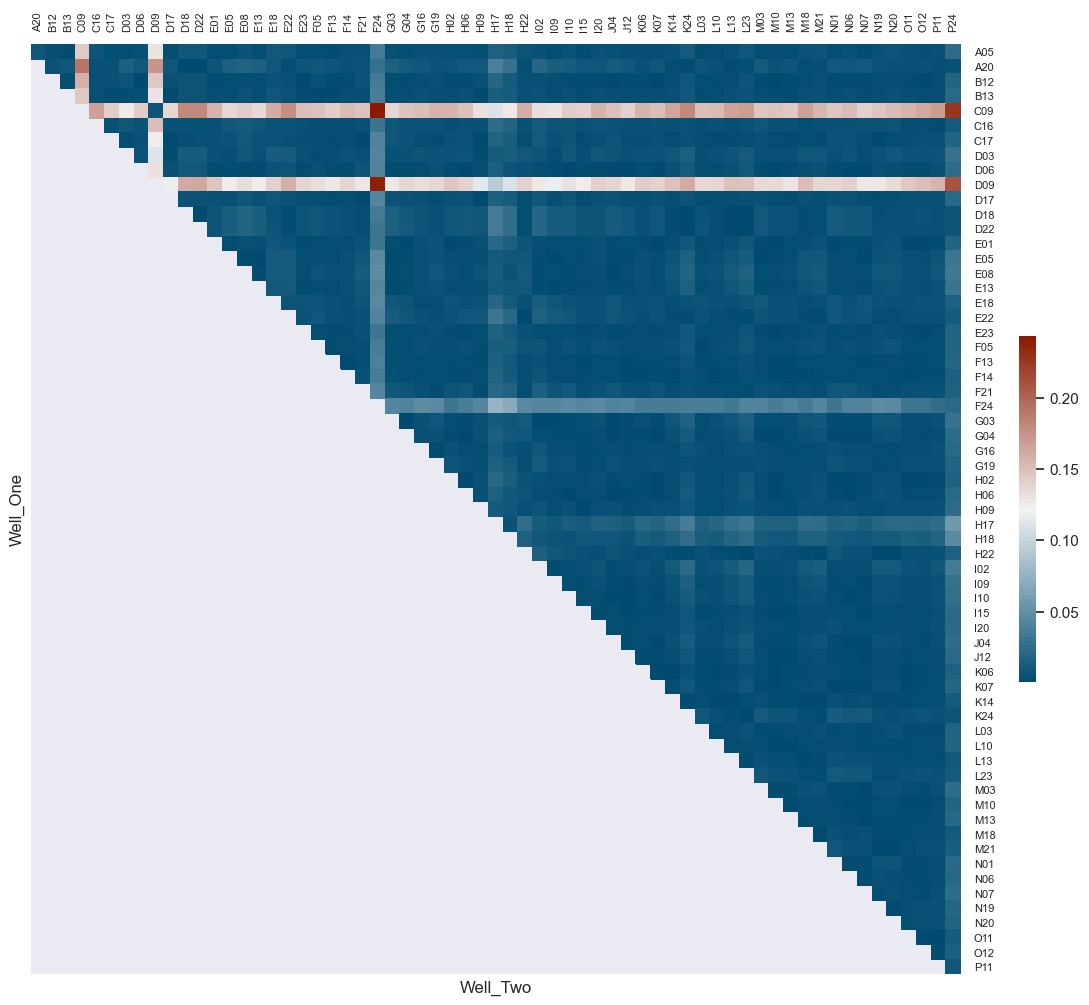

In [123]:
plt.figure()
sb.set(rc={"figure.figsize": (15, 15)})
colmap = sb.diverging_palette(240, 15, s=100, l=30, as_cmap=True)

ax = sb.heatmap(
    Y,
    cmap=colmap,
    square=True,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={"shrink": 0.30},
)
plt.tick_params(
    axis="both",
    which="major",
    rotation=90,
    labelsize=8,
    labelbottom=False,
    bottom=False,
    top=False,
    labeltop=True,
    right=False,
    labelright=True,
    left=False,
    labelleft=False,
)
plt.yticks(rotation=0)
# ax.set_aspect("equal")
plt.show()

In [103]:
Y

Well_Two,A20,B12,B13,C09,C16,C17,D03,D06,D09,D17,...,M21,N01,N06,N07,N19,N20,O11,O12,P11,P24
Well_One,,,,,,,,,,,,,,,,,,,,,
A05,0.990397,0.996731,0.998628,0.856164,0.993045,0.997037,0.997302,0.995525,0.869160,0.997604,...,0.992644,0.997037,0.994565,0.998102,0.994938,0.992745,0.995887,0.996603,0.994977,0.976100
A20,1.000000,0.993395,0.991505,0.808733,0.995444,0.994109,0.985321,0.989378,0.825909,0.991796,...,0.996314,0.989426,0.990474,0.989521,0.993945,0.994022,0.995391,0.994632,0.996403,0.994551
B12,0.000000,1.000000,0.997166,0.841413,0.995775,0.995468,0.992832,0.998855,0.853864,0.995153,...,0.995436,0.997880,0.998636,0.998417,0.995954,0.996094,0.998595,0.999269,0.997209,0.981031
B13,0.000000,0.000000,1.000000,0.854674,0.995544,0.997973,0.998181,0.996413,0.870541,0.998759,...,0.994622,0.996980,0.995145,0.998025,0.996373,0.994494,0.996839,0.997603,0.996525,0.978655
C09,0.000000,0.000000,0.000000,1.000000,0.833201,0.857784,0.874387,0.856691,0.992105,0.863821,...,0.844846,0.853433,0.848531,0.859020,0.853226,0.848746,0.843250,0.836652,0.830268,0.773522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.996406,0.995665,0.994420,0.981955
O11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.999328,0.999081,0.987112
O12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.998702,0.985046
